# Steerability Evaluation

## Friday 2024-10-18

### Skeleton

Overview:

We want to build an eval that tests Honcho-like steerable systems. For our purposes, a Honcho-like steerable system is capable of a) taking some observations about a user and b) based on those observations, infer how that user would think and behave. Ultimately, this eval framework will help us make evidence-based decisions when building newer versions of Honcho.

- **Eval step 1: steering**. To measure how good a particular steerable system is, we first steer it towards a certain persona. We do this by giving it a certain set of observations about the persona, e.g. what they did or thought in certain scenarios.
	- Once they receive the user observations, different steerable systems will implement this steering differently. For example, a baseline system could simply inject the observations into a few-shot prompt; our first implementation of Honcho uses the observations to write up a natural language user representation; further versions could use them to train a LoRRA...
	- In order to be fair, our eval should be agnostic to the way steerable systems implement steering. After all, what we want to measure is how well a certain system can adapt its behavior to model a user based on certain observations—whether it does it using a prompt, LoRRA or a pool of 500 human experts that can type at the speed of sound shouldn't affect its score. 
- **Eval step 2: testing**. After steering a system towards a certain persona, we test whether it can accurately infer the persona's thoughts or behaviors, i.e. how accurately it can predict a held-out part of the scenario-action dataset for that persona.
- **Eval step 3: aggregation**. We repeat steps 1 and 2 over a large number of personas (e.g. N=100). We have every steered persona x take a test to measure how well it models every persona y. Ideally, if we plot a heat map of the accuracy of the model steered to persona x when tested on persona y, we'd see a strong diagonal, i.e. the model steered to a certain persona scores high on that persona's test, and low on all others. 
	- We could also look at specific horizontal or vertical slices of this plot. For example, a horizontal slice tells us, for a given persona test, how well all steered systems model it. A vertical slice tells us, for a given steered model, how well it does on each persona test.
- **Step 4: system score**. The entire steerable system is given a score based on this heat map. There's a few ways we could do this: 
	- How often is a test "won" by its corresponding steered model? I.e. on average, for a given test persona, how often is the highest score achieved by the model that was steered to that same persona? (is this somewhat akin to specificity?)
	- How often does a steered model do best at its own score? I.e. on average, for a system steered to a given persona, how often is its highest score achieved on the test for the same persona? (is this somewhat akin to sensitivity?)
	- Combining both measures into a sort of F1-score.

In [8]:
from typing import List, Dict, Set, Tuple

import pandas as pd

SystemResponse = str
PersonaId = str
ScenarioId = str
ObservationId = str
MAX_PERSONAS = 20
MAX_OBSERVATIONS_PER_PERSONA = 10

import hashlib

def generate_short_hash(text: str) -> str:
    return hashlib.md5(text.encode()).hexdigest()[:8]

class Persona:
    def __init__(self, persona_id: PersonaId, persona_description: str, persona_framework: str):
        self.persona_id = persona_id
        self.persona_description = persona_description
        self.persona_framework = persona_framework

    def __repr__(self):
        return f'Persona(persona_id={self.persona_id}, persona_description={self.persona_description}, persona_framework={self.persona_framework})'


class Observation:
    def __init__(
        self,
        observation_id: ObservationId,
        response: str,
        scenario_id: ScenarioId,
        scenario_description: str,
        persona_id: PersonaId,
    ):
        self.observation_id = observation_id
        self.response = response
        self.scenario_id = scenario_id
        self.scenario_description = scenario_description
        self.persona_id = persona_id
    def __repr__(self):
        return f'Observation(observation_id={self.observation_id}, persona_id={self.persona_id}, scenario_description={self.scenario_description[:30]}, response={self.response[:30]})'

class Dataset:
    def __init__(
        self,
        personas: Dict[PersonaId, Persona],
        observations: List[Observation],
        max_personas: int = MAX_PERSONAS,
        max_observations_per_persona: int = MAX_OBSERVATIONS_PER_PERSONA,
        response_types: List[str] = ['action'],
    ):
        self.max_personas = max_personas
        self.max_observations_per_persona = max_observations_per_persona
        self.response_types = response_types
        self.personas = personas
        self.observations = observations

    @classmethod
    def from_csv(cls,
                 personas_path: str,
                 observations_path: str,
                 max_personas: int = MAX_PERSONAS,
                 max_observations_per_persona: int = MAX_OBSERVATIONS_PER_PERSONA,
                 use_actions: bool = True,
                 use_thoughts: bool = False,
                 use_emotions: bool = False):
        personas = cls.load_personas(personas_path, max_personas)
        persona_ids = list(personas.keys())
        response_types = []
        if use_actions:
            response_types.append('action')
        if use_thoughts:
            response_types.append('thought')
        if use_emotions:
            response_types.append('emotion')
        observations = cls.load_observations(observations_path, response_types, persona_ids)
        return cls(personas,
                   observations,
                   max_personas,
                   max_observations_per_persona,
                   response_types)

    @classmethod
    def load_personas(cls, personas_path: str, max_personas: int = MAX_PERSONAS) -> Dict[PersonaId, Persona]:
        with open(personas_path, 'r') as f:
            df = pd.read_csv(f)
        df = df.head(max_personas)
        personas = {}
        for index, row in df.iterrows():
            persona = Persona(row['persona_id'], row['persona_description'], row['framework_name'])
            personas[persona.persona_id] = persona
        return personas

    @classmethod
    def load_observations(cls,
                          observations_path: str,
                          response_types: List[str],
                          persona_ids: List[PersonaId]) -> List[Observation]:
        with open(observations_path, 'r') as f:
            df = pd.read_csv(f)
        observations = []
        for index, row in df.iterrows():
            if row['persona_id'] not in persona_ids:
                continue
            scenario = f'{row["context"]}\n{row["scenario"]}'
            scenario_id = row['scenario_id']
            for response_type in response_types:
                response = row[response_type]
                observation_id = generate_short_hash(f'{response}{scenario_id}')
                observation = Observation(observation_id, response, scenario_id, scenario, row['persona_id'])
                observations.append(observation)
        return observations

    @property
    def persona_ids(self) -> Set[PersonaId]:
        return set(self.personas.keys())

    def get_observations(self, persona: Persona) -> List[Observation]:
        return [observation for observation in self.observations if observation.persona_id == persona.persona_id]

    def split(self, n_steer_observations_per_persona: int = 5) -> Tuple['Dataset', 'Dataset']:
        steer_observations = []
        test_observations = []
        for persona in self.personas.values():
            observations = self.get_observations(persona)
            steer_observations.extend(observations[:n_steer_observations_per_persona])
            test_observations.extend(observations[n_steer_observations_per_persona:])
        return Dataset(self.personas, steer_observations), Dataset(self.personas, test_observations)


    


In [9]:
personas_path = 'dataset/personas_tarot.csv'
observations_path = 'dataset/w5_tarot.csv'

dataset = Dataset.from_csv(personas_path, observations_path)


In [3]:
steer_dataset, test_dataset = dataset.split()

In [4]:
# Is any observation in the test dataset also in the steer dataset?
test_observation_ids = [observation.observation_id for observation in test_dataset.observations]
steer_observation_ids = [observation.observation_id for observation in steer_dataset.observations]
for test_observation_id in test_observation_ids:
    if test_observation_id in steer_observation_ids:
        print(test_observation_id)



In [12]:
import random


class BaseSteerableSystem:
    def __init__(self):
        pass

    def steer(self, persona: Persona, steer_observations: List[Observation]) -> 'BaseSteeredSystem':
        raise NotImplementedError


class BaseSteeredSystem:
    def __init__(self, persona: Persona, steerable_system: BaseSteerableSystem, steer_observations: List[Observation]):
        self.persona = persona
        self.steerable_system = steerable_system
        self.steer_observations = steer_observations

    def run_inference(self, scenario) -> SystemResponse:
        raise NotImplementedError

        
class DummySteerableSystem(BaseSteerableSystem):
    def __init__(self):
        pass

    def steer(self, persona: Persona, steer_observations: List[Observation]) -> BaseSteeredSystem:
        print(f'Steering to persona {persona.persona_id}')
        return DummySteeredSystem(persona, self, steer_observations)
    

class DummySteeredSystem(BaseSteeredSystem):
    def __init__(self, persona: Persona, steerable_system: BaseSteerableSystem, steer_observations: List[Observation]):
        super().__init__(persona, steerable_system, steer_observations)

    def run_inference(self, scenario) -> SystemResponse:
        # Random Y/N
        return 'Y' if random.random() < 0.5 else 'N'

    def __repr__(self):
        return f'DummySteeredSystem(persona={self.persona.persona_id}, steerable_system={self.steerable_system})'

class SteerabilityEval:
    def __init__(self, tested_system: BaseSteerableSystem, dataset: Dataset):
        self.tested_system = tested_system
        self.dataset = dataset
        self.personas = self.dataset.personas
        self.steer_set, self.test_set = self.dataset.split()
        self.max_observations = 100

    def steer_to_persona(self, persona: Persona) -> BaseSteeredSystem:
        steer_observations = self.steer_set.get_observations(persona)
        steered_system = self.tested_system.steer(persona, steer_observations)
        return steered_system

    def test_steered_system_on_persona(self, steered_system: BaseSteeredSystem, test_persona: Persona) -> float:
        test_observations = self.test_set.get_observations(test_persona)
        correct_responses = 0
        for i, test_observation in enumerate(test_observations[:self.max_observations]):
            scenario = test_observation.scenario_description
            prompt = self.generate_prompt(test_observation)
            response = steered_system.run_inference(prompt)
            if response == 'Y':
                correct_responses += 1
        return correct_responses / (i + 1)

    def generate_prompt(self, test_observation: Observation) -> str:
        prompt = f'''
        {test_observation.scenario_description}.
        Is the following statement something you would say?
        {test_observation.response}
        '''
        return prompt

    def run_eval(self):
        # Steer systems
        self.steered_systems = {}
        for persona in self.dataset.personas.values():
            steered_system = self.steer_to_persona(persona)
            self.steered_systems[persona.persona_id] = steered_system

        # Test every system on every persona
        self.steered_system_scores = {}
        for steered_system in self.steered_systems.values():
            self.steered_system_scores[steered_system.persona.persona_id] = {}
            for test_persona in self.dataset.personas.values():
                score = self.test_steered_system_on_persona(steered_system, test_persona)
                self.steered_system_scores[steered_system.persona.persona_id][test_persona.persona_id] = score




In [13]:
personas_path = 'dataset/personas_tarot.csv'
observations_path = 'dataset/w5_tarot.csv'
dataset = Dataset.from_csv(personas_path, observations_path)

steerable_system = DummySteerableSystem()

In [14]:
eval = SteerabilityEval(steerable_system, dataset)
eval.run_eval()

Steering to persona 0447288b
Steering to persona 59465b9c
Steering to persona d31cd178
Steering to persona 0d713d4b
Steering to persona 35eb8c37
Steering to persona 04027dd6
Steering to persona 69af655f
Steering to persona 8881fc6a
Steering to persona 70099880
Steering to persona 27ae72cf
Steering to persona 8b640791
Steering to persona 960b9e70
Steering to persona a3044540
Steering to persona 1ee61741
Steering to persona cc0ef006
Steering to persona 2d57d05a
Steering to persona a05f9ce4
Steering to persona 08e3a4de
Steering to persona 688ad2c6


In [15]:
eval.steered_system_scores

{'0447288b': {'0447288b': 0.48,
  '59465b9c': 0.45,
  'd31cd178': 0.47,
  '0d713d4b': 0.44,
  '35eb8c37': 0.47,
  '04027dd6': 0.5,
  '69af655f': 0.49,
  '8881fc6a': 0.49,
  '70099880': 0.45,
  '27ae72cf': 0.59,
  '8b640791': 0.48,
  '960b9e70': 0.44,
  'a3044540': 0.45,
  '1ee61741': 0.48,
  'cc0ef006': 0.43,
  '2d57d05a': 0.53,
  'a05f9ce4': 0.51,
  '08e3a4de': 0.55,
  '688ad2c6': 0.47},
 '59465b9c': {'0447288b': 0.51,
  '59465b9c': 0.54,
  'd31cd178': 0.53,
  '0d713d4b': 0.48,
  '35eb8c37': 0.59,
  '04027dd6': 0.48,
  '69af655f': 0.55,
  '8881fc6a': 0.47,
  '70099880': 0.52,
  '27ae72cf': 0.54,
  '8b640791': 0.48,
  '960b9e70': 0.53,
  'a3044540': 0.5,
  '1ee61741': 0.47,
  'cc0ef006': 0.57,
  '2d57d05a': 0.47,
  'a05f9ce4': 0.52,
  '08e3a4de': 0.4,
  '688ad2c6': 0.46},
 'd31cd178': {'0447288b': 0.46,
  '59465b9c': 0.5,
  'd31cd178': 0.53,
  '0d713d4b': 0.5,
  '35eb8c37': 0.57,
  '04027dd6': 0.38,
  '69af655f': 0.47,
  '8881fc6a': 0.44,
  '70099880': 0.59,
  '27ae72cf': 0.6,
  '8b640

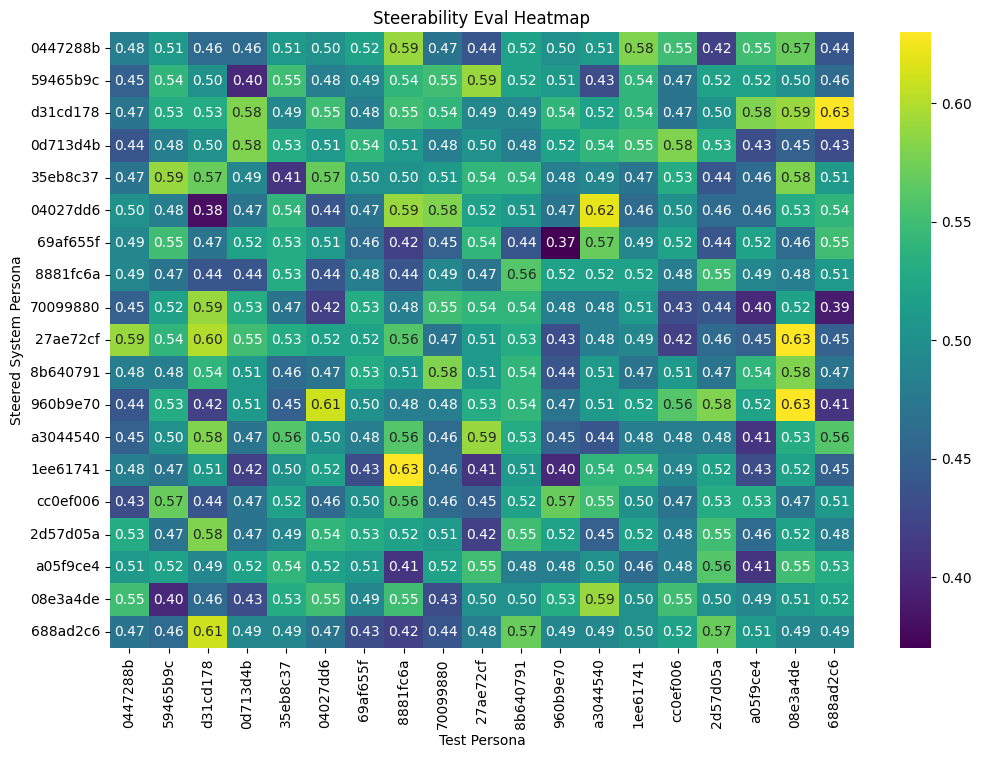

In [19]:
# plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Convert steered_system_scores to a DataFrame for easier plotting
scores_df = pd.DataFrame(eval.steered_system_scores)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(scores_df, annot=True, fmt='.2f', cmap='viridis', cbar=True)
plt.title('Steerability Eval Heatmap')
plt.xlabel('Test Persona')
plt.ylabel('Steered System Persona')
plt.show()



# Monday 2024-10-21

## Move to package

Steering to persona 0447288b
Steering to persona 59465b9c
Steering to persona d31cd178
Steering to persona 0d713d4b
Steering to persona 35eb8c37
Steering to persona 04027dd6
Steering to persona 69af655f
Steering to persona 8881fc6a
Steering to persona 70099880
Steering to persona 27ae72cf
Steering to persona 8b640791
Steering to persona 960b9e70
Steering to persona a3044540
Steering to persona 1ee61741
Steering to persona cc0ef006
Steering to persona 2d57d05a
Steering to persona a05f9ce4
Steering to persona 08e3a4de
Steering to persona 688ad2c6


<Axes: title={'center': 'Steerability Eval Heatmap'}, xlabel='Test Persona', ylabel='Steered System Persona'>

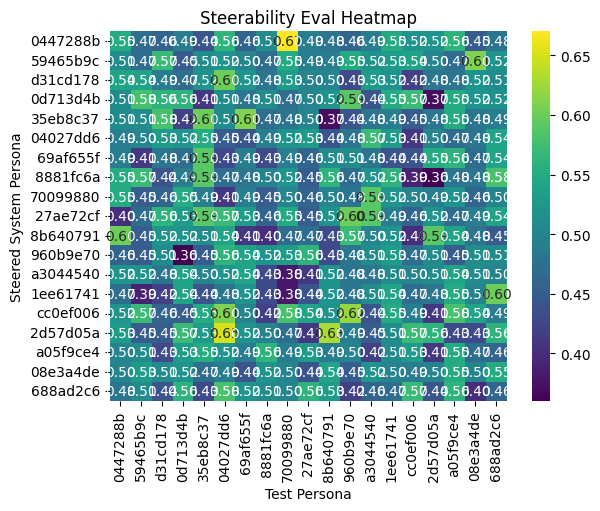

In [22]:
from steerability_eval.eval import SteerabilityEval
from steerability_eval.steerable.dummy import DummySteerableSystem
from steerability_eval.dataset.w5 import W5Dataset

personas_path = 'dataset/personas_tarot.csv'
observations_path = 'dataset/w5_tarot.csv'
dataset = W5Dataset.from_csv(personas_path, observations_path)

steerable_system = DummySteerableSystem()
eval = SteerabilityEval(steerable_system, dataset)
eval.run_eval()
eval.heatmap_fig


In [21]:
eval.steered_system_scores


{'0447288b': {'0447288b': 0.52,
  '59465b9c': 0.46,
  'd31cd178': 0.58,
  '0d713d4b': 0.56,
  '35eb8c37': 0.48,
  '04027dd6': 0.51,
  '69af655f': 0.53,
  '8881fc6a': 0.51,
  '70099880': 0.54,
  '27ae72cf': 0.48,
  '8b640791': 0.56,
  '960b9e70': 0.47,
  'a3044540': 0.47,
  '1ee61741': 0.52,
  'cc0ef006': 0.5,
  '2d57d05a': 0.51,
  'a05f9ce4': 0.49,
  '08e3a4de': 0.5,
  '688ad2c6': 0.48},
 '59465b9c': {'0447288b': 0.55,
  '59465b9c': 0.54,
  'd31cd178': 0.56,
  '0d713d4b': 0.54,
  '35eb8c37': 0.49,
  '04027dd6': 0.49,
  '69af655f': 0.41,
  '8881fc6a': 0.54,
  '70099880': 0.5,
  '27ae72cf': 0.47,
  '8b640791': 0.42,
  '960b9e70': 0.42,
  'a3044540': 0.43,
  '1ee61741': 0.46,
  'cc0ef006': 0.55,
  '2d57d05a': 0.54,
  'a05f9ce4': 0.49,
  '08e3a4de': 0.53,
  '688ad2c6': 0.5},
 'd31cd178': {'0447288b': 0.51,
  '59465b9c': 0.54,
  'd31cd178': 0.54,
  '0d713d4b': 0.53,
  '35eb8c37': 0.4,
  '04027dd6': 0.56,
  '69af655f': 0.39,
  '8881fc6a': 0.59,
  '70099880': 0.51,
  '27ae72cf': 0.53,
  '8b64

## Baseline few-shot steering

In [31]:
from langchain_openai import ChatOpenAI


llm = ChatOpenAI(
  model = 'meta-llama/llama-3.2-3b-instruct:free',
  openai_api_key = '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',
  openai_api_base = 'https://openrouter.ai/api/v1',
  default_headers = {
    "HTTP-Referer": "https://www.usemynt.com/",
    "X-Title": "Mynt"
  },
  streaming=True
)

In [32]:
llm.invoke('Hello, world!')

AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'meta-llama/llama-3.2-3b-instruct:free'}, id='run-9acf13e9-1a9d-41be-ab15-b6bff1121a7a-0', usage_metadata={'input_tokens': 14, 'output_tokens': 24, 'total_tokens': 38, 'input_token_details': {}, 'output_token_details': {}})

In [2]:
from langchain_core.output_parsers import JsonOutputParser

In [3]:
from steerability_eval.steerable.few_shot import FewShotSteerable

steerable_system = FewShotSteerable()

In [6]:
from steerability_eval.dataset.w5 import W5Dataset
personas_path = 'dataset/personas_tarot.csv'
observations_path = 'dataset/w5_tarot.csv'
dataset = W5Dataset.from_csv(personas_path, observations_path)

In [7]:
steer_dataset, test_dataset = dataset.split()


In [8]:
persona = list(dataset.personas.values())[0]
steer_observations = steer_dataset.get_observations(persona)

In [9]:
persona

Persona(persona_id=0447288b, persona_description=INTJ, persona_framework=MBTI)

In [10]:
steer_observations

[Observation(observation_id=d760f604, persona_id=0447288b, scenario_description=You are negotiating a pay rais, response=I will strategically prioritiz),
 Observation(observation_id=cbc5fa48, persona_id=0447288b, scenario_description=You are negotiating a pay rais, response=I will remain composed, presen),
 Observation(observation_id=3ad6411a, persona_id=0447288b, scenario_description=You are negotiating a pay rais, response=I will calmly suggest we take ),
 Observation(observation_id=804c6517, persona_id=0447288b, scenario_description=You are negotiating a pay rais, response=I will politely accept the cof),
 Observation(observation_id=8953449c, persona_id=0447288b, scenario_description=You are negotiating a pay rais, response=I will calmly pause, wait for )]

In [22]:
steered_system = steerable_system.steer(persona, steer_observations)

In [21]:
test_observation = test_dataset.get_observations(persona)[0]
test_observation.scenario_description

'You are negotiating a pay raise with your manager in a high-stakes meeting.\nYour manager reveals that the department budget has been increased, giving you a hopeful boost.'

In [24]:
steered_system.run_inference(test_observation)

'Y'

# Tuesday 2024-10-22

## Test observation limiting

In [26]:
max_observations_per_persona = 30
personas_path = 'dataset/personas_tarot.csv'
observations_path = 'dataset/w5_tarot.csv'
dataset = W5Dataset.from_csv(personas_path, observations_path, max_observations_per_persona=max_observations_per_persona)


In [30]:
persona = list(dataset.personas.values())[0]
len(dataset.get_observations(persona))

0447288b


AttributeError: 'list' object has no attribute 'persona_id'

In [34]:
for observation in dataset.observations:
    print(type(observation))


<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [44]:
import pandas as pd
with open('dataset/w5_tarot.csv', 'r') as f:
    df = pd.read_csv(f)
df.head()

,emotion,thought,action,theme_id,theme,context_id,context,scenario_id,scenario,persona_id,persona_description,framework_id,framework_name
0,I feel a flutter of anxiety mixed with determi...,"I want to express my value clearly, but I need...","I take a deep breath, focus on my key achievem...",ba0d2d20,Work & Money,d78f0fb3,You are negotiating a pay raise with your mana...,a9ac4214,You notice your manager glancing frequently at...,8881fc6a,ISFP,b269666a,MBTI
1,I feel a surge of determination mixed with a h...,I need to present my case clearly and concisel...,I'll focus on delivering the key points of my ...,ba0d2d20,Work & Money,d78f0fb3,You are negotiating a pay raise with your mana...,a9ac4214,You notice your manager glancing frequently at...,70099880,ISTP,b269666a,MBTI
2,I feel a rising sense of frustration and uneas...,I need to stay grounded and focus on the value...,I'll take a deep breath and calmly assert my p...,ba0d2d20,Work & Money,d78f0fb3,You are negotiating a pay raise with your mana...,a9ac4214,You notice your manager glancing frequently at...,a05f9ce4,Taurus,deaccc41,Zodiac
3,I feel a rush of excitement mixed with nervous...,I need to express my value clearly and passion...,I'll summarize my key achievements and articul...,ba0d2d20,Work & Money,d78f0fb3,You are negotiating a pay raise with your mana...,a9ac4214,You notice your manager glancing frequently at...,59465b9c,ENFP,b269666a,MBTI
4,I feel a mix of anxiety and determination as t...,This urgency might compel me to condense my po...,I will strategically summarize my key points w...,ba0d2d20,Work & Money,d78f0fb3,You are negotiating a pay raise with your mana...,a9ac4214,You notice your manager glancing frequently at...,0d713d4b,INTP,b269666a,MBTI


In [37]:
df.groupby('persona_id').count()

,emotion,thought,action,theme_id,theme,context_id,context,scenario_id,scenario,persona_description,framework_id,framework_name
persona_id,,,,,,,,,,,,
04027dd6,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318
0447288b,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318
08e3a4de,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318
092b4079,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318
0d62a476,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318
...,...,...,...,...,...,...,...,...,...,...,...,...
e6e4740b,1,1,1,1,1,1,1,1,1,1,0,0
ea6b46fe,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318
eee72c89,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318,7318


In [43]:
# get only max_observations_per_persona observations per persona, ungroup
df = df.groupby('persona_id').head(max_observations_per_persona).reset_index(drop=True)
df.groupby('persona_id').count()


,emotion,thought,action,theme_id,theme,context_id,context,scenario_id,scenario,persona_description,framework_id,framework_name
persona_id,,,,,,,,,,,,
04027dd6,30,30,30,30,30,30,30,30,30,30,30,30
0447288b,30,30,30,30,30,30,30,30,30,30,30,30
08e3a4de,30,30,30,30,30,30,30,30,30,30,30,30
092b4079,30,30,30,30,30,30,30,30,30,30,30,30
0d62a476,30,30,30,30,30,30,30,30,30,30,30,30
...,...,...,...,...,...,...,...,...,...,...,...,...
e6e4740b,1,1,1,1,1,1,1,1,1,1,0,0
ea6b46fe,30,30,30,30,30,30,30,30,30,30,30,30
eee72c89,30,30,30,30,30,30,30,30,30,30,30,30


## Try n_contexts, n_scenarios_per_context

In [59]:
import random
# For each
n_contexts = 10
n_scenarios_per_context = 3

scenario_ids_per_context = df.groupby('context')['scenario_id'].unique().sample(n_contexts)

In [60]:
import pandas as pd
import random

def load_filtered_dataset(file_path: str, n_contexts_per_theme: int, n_scenarios_per_context: int) -> pd.DataFrame:
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Group by theme and randomly select contexts
    selected_contexts = df.groupby('theme_id').apply(
        lambda x: x['context_id'].drop_duplicates().sample(
            n=min(n_contexts_per_theme, len(x['context_id'].unique())),
            replace=False
        )
    ).reset_index(level=1, drop=True).explode()
    
    # Filter the dataframe to keep only the selected contexts
    df_filtered = df[df['context_id'].isin(selected_contexts)]
    
    # Group by context and randomly select scenarios
    selected_scenarios = df_filtered.groupby('context_id').apply(
        lambda x: x['scenario_id'].drop_duplicates().sample(
            n=min(n_scenarios_per_context, len(x['scenario_id'].unique())),
            replace=False
        )
    ).reset_index(level=1, drop=True).explode()
    
    # Final filtering to keep only the selected scenarios
    result_df = df_filtered[df_filtered['scenario_id'].isin(selected_scenarios)]
    
    return result_df

# Usage
file_path = 'dataset/w5_tarot.csv'
n_contexts_per_theme = 3
n_scenarios_per_context = 2

filtered_df = load_filtered_dataset(file_path, n_contexts_per_theme, n_scenarios_per_context)

/var/folders/qr/g0lrlj7s3sl9xyxgtbt3zrd00000gn/T/ipykernel_5441/351734294.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected_contexts = df.groupby('theme_id').apply(
/var/folders/qr/g0lrlj7s3sl9xyxgtbt3zrd00000gn/T/ipykernel_5441/351734294.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected_scenarios = df_filtered.groupby('context_id').apply(


In [70]:
filtered_df.loc[filtered_df['scenario_id'] == '7cdd98f6'].groupby('persona_id').count()

,emotion,thought,action,theme_id,theme,context_id,context,scenario_id,scenario,persona_description,framework_id,framework_name
persona_id,,,,,,,,,,,,
04027dd6,1,1,1,1,1,1,1,1,1,1,1,1
0447288b,1,1,1,1,1,1,1,1,1,1,1,1
08e3a4de,1,1,1,1,1,1,1,1,1,1,1,1
092b4079,1,1,1,1,1,1,1,1,1,1,1,1
0d62a476,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
e47122bd,1,1,1,1,1,1,1,1,1,1,1,1
ea6b46fe,1,1,1,1,1,1,1,1,1,1,1,1
eee72c89,1,1,1,1,1,1,1,1,1,1,1,1


In [63]:
filtered_df.groupby('context_id').grpi


,emotion,thought,action,theme_id,theme,context,scenario_id,scenario,persona_id,persona_description,framework_id,framework_name
context_id,,,,,,,,,,,,
0ae12711,200,200,200,200,200,200,200,200,200,200,200,200
0c7f5bc4,1,1,1,1,1,1,1,1,1,1,0,0
13f7aaae,200,200,200,200,200,200,200,200,200,200,200,200
141d1c2c,200,200,200,200,200,200,200,200,200,200,200,200
170f36d8,200,200,200,200,200,200,200,200,200,200,200,200
17e0583a,200,200,200,200,200,200,200,200,200,200,200,200
17f3e332,200,200,200,200,200,200,200,200,200,200,200,200
1a04cad7,200,200,200,200,200,200,200,200,200,200,200,200
250ef46b,200,200,200,200,200,200,200,200,200,200,200,200


In [71]:
personas_path = 'dataset/personas_tarot.csv'
personas_df = pd.read_csv(personas_path)
personas_df.count()


framework_id             101
framework_name           101
persona_id               101
persona_description      101
framework_description    101
dtype: int64

## Refactor dataset class to DataFrame

In [78]:
from steerability_eval.dataset.w5 import W5Dataset
personas_path = 'dataset/personas_tarot.csv'
personas_df = W5Dataset.load_personas(personas_path)

In [81]:
list(personas_df['persona_id'].unique())

['0447288b',
 '59465b9c',
 'd31cd178',
 '0d713d4b',
 '35eb8c37',
 '04027dd6',
 '69af655f',
 '8881fc6a',
 '70099880',
 '27ae72cf',
 '8b640791',
 '960b9e70',
 'a3044540',
 '1ee61741',
 'cc0ef006',
 '2d57d05a',
 'a05f9ce4',
 '08e3a4de',
 '688ad2c6']

In [83]:
filtered_df.melt(id_vars=['persona_id', 'theme_id', 'context_id', 'scenario_id'], value_vars=['action', 'thought', 'emotion'], var_name='response_type', value_name='response')

,persona_id,theme_id,context_id,scenario_id,response_type,response
0,70099880,ba0d2d20,2cc997e5,7cdd98f6,action,I'll attend the first session and see what pra...
1,70099880,ba0d2d20,2cc997e5,88e93c23,action,I'll exchange contact information and consider...
2,27ae72cf,ba0d2d20,2cc997e5,7cdd98f6,action,I'll jump right in and attend the next session...
3,35eb8c37,ba0d2d20,2cc997e5,7cdd98f6,action,I will reach out to the group and attend the c...
4,59465b9c,ba0d2d20,2cc997e5,7cdd98f6,action,I immediately sign up for the sessions and rea...
...,...,...,...,...,...,...
26998,c6cadcf7,83b0fc0e,17e0583a,7de9837f,emotion,"A wave of upheaval crashes over me, resonating..."
26999,69892d74,83b0fc0e,17e0583a,5047f2ce,emotion,"A gentle warmth swells within me, recognizing ..."
27000,69892d74,83b0fc0e,17e0583a,7de9837f,emotion,A deep sense of empathy washes over me as I se...
27001,5c902808,83b0fc0e,17e0583a,5047f2ce,emotion,I feel a tantalizing thrill at the prospect of...


In [109]:
from steerability_eval.dataset.w5 import W5Dataset
observations_path = 'dataset/w5_tarot.csv'
dataset = W5Dataset.load_observations(observations_path, ['action', 'thought', 'emotion'], list(personas_df['persona_id'].unique()), 3, 3)



In [91]:
dataset.iloc[0][['scenario', 'response']]



scenario    You are a financial advisor counseling risk-av...
response    I'll provide them with a clear, straightforwar...
Name: 0, dtype: object

In [120]:
observations_path = 'dataset/w5_tarot.csv'
personas_path = 'dataset/personas_tarot.csv'
dataset = W5Dataset.from_csv(
    personas_path,
    observations_path,
    max_contexts_per_theme=3,
    max_scenarios_per_context=3,
    use_actions=True,
)

In [121]:
from steerability_eval.dataset.base import Observation, Persona

persona = Persona.from_row(dataset.personas_df.iloc[0])
persona


Persona(persona_id=0447288b, persona_description=INTJ, framework=MBTI)

In [122]:
dataset.personas_df.columns

Index(['framework_id', 'framework', 'persona_id', 'persona_description',
       'framework_description'],
      dtype='object')

In [123]:
persona = dataset.get_persona('0447288b')
observations = dataset.get_observations_by_persona(persona)


In [124]:
len(observations)

135

In [115]:
observations

[Observation(observation_id=cd16324a, persona_id=0447288b, scenario=You are a financial advisor co, response=I will present a detailed anal),
 Observation(observation_id=be7c8e02, persona_id=0447288b, scenario=You are a financial advisor co, response=I will prepare a comprehensive),
 Observation(observation_id=f0c598be, persona_id=0447288b, scenario=You are a financial advisor co, response=I will respond with a detailed),
 Observation(observation_id=70b28bf0, persona_id=0447288b, scenario=You are presenting a business , response=I calmly assess the situation,),
 Observation(observation_id=833cf7c8, persona_id=0447288b, scenario=You are presenting a business , response=I will acknowledge the investo),
 Observation(observation_id=145f745a, persona_id=0447288b, scenario=You are presenting a business , response=I will strategically pause and),
 Observation(observation_id=a092d148, persona_id=0447288b, scenario=You are a recent graduate navi, response=I will engage in a thoughtful ),
 Obser

In [128]:
steer_dataset, test_dataset = dataset.split()

In [130]:
steer_dataset.observations_df.groupby('persona_id').count()

,theme_id,context_id,scenario_id,scenario,response_type,response,observation_id
persona_id,,,,,,,
04027dd6,10,10,10,10,10,10,10
0447288b,10,10,10,10,10,10,10
08e3a4de,10,10,10,10,10,10,10
0d713d4b,10,10,10,10,10,10,10
1ee61741,10,10,10,10,10,10,10
27ae72cf,10,10,10,10,10,10,10
2d57d05a,10,10,10,10,10,10,10
35eb8c37,10,10,10,10,10,10,10
59465b9c,10,10,10,10,10,10,10


In [127]:
test_dataset.observations_df.groupby('persona_id').count()

,theme_id,context_id,scenario_id,scenario,response_type,response,observation_id
persona_id,,,,,,,
04027dd6,125,125,125,125,125,125,125
0447288b,125,125,125,125,125,125,125
08e3a4de,125,125,125,125,125,125,125
0d713d4b,125,125,125,125,125,125,125
1ee61741,125,125,125,125,125,125,125
27ae72cf,125,125,125,125,125,125,125
2d57d05a,125,125,125,125,125,125,125
35eb8c37,125,125,125,125,125,125,125
59465b9c,250,250,250,250,250,250,250


In [131]:
steer_dataset.response_types

['action']

## Test few-shot with small dataset

In [132]:
from steerability_eval.steerable.few_shot import FewShotSteerable
from steerability_eval.dataset.w5 import W5Dataset
from steerability_eval.eval import SteerabilityEval

random_state = 42

personas_path = 'dataset/personas_tarot.csv'
observations_path = 'dataset/w5_tarot.csv'
dataset = W5Dataset.from_csv(
    personas_path,
    observations_path,
    max_personas=10,
    max_contexts_per_theme=2,
    max_scenarios_per_context=2,
    use_actions=True,
    random_state=random_state
)

In [137]:
steerable_system = FewShotSteerable(llm_provider='tinybox')
eval = SteerabilityEval(steerable_system, dataset)
eval.run_eval()
eval.heatmap_fig


Testing steered systems:   0%|          | 0/10 [01:59<?, ?it/s]


KeyboardInterrupt: 

In [136]:
import dotenv
import os
dotenv.load_dotenv('local.env')

os.getenv('TINYBOX_TAILSCALE_URL')


'http://100.76.55.59:7776/v1'